# Logistic Regression with Python

在本次的課堂中，我們將會使用[Titanic Data Set from Kaggle](https://www.kaggle.com/c/titanic)，這是一個非常知名的資料集，也是很多人初次接觸機器學習領域時，第一個使用到的資料集

我們將會嘗試使用Logistic Regression來預測Titanic的乘客是否能在冰山撞擊中存活或是會罹難

以下是我們將用來預測的資料集長相：

Variable      | Definition  | Key 
--------------|:-----------:|-----:
PassengerId   | PassengerId |
survival      | Survival | 0 = No, 1 = Yes
pclass        | Ticket class |  1 = 1st, 2 = 2nd, 3 = 3rd
Name          | Name |
sex           | Sex |      
Age           | Age | 
sibsp         | # of siblings / spouses aboard the Titanic | 
parch         | # of parents / children aboard the Titanic | 
ticket        | Ticket number | 
fare          | Passenger fare | 
cabin         | Cabin number | 
embarked      | Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton | 

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## The Data

首先我們將titanic_train.csv檔案讀取進入到Pandas中成為dataframe型態

In [2]:
train = pd.read_csv('titanic_train.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Exploratory Data Analysis

我們可以透過將資料視覺化的方式，直觀的查看資料的分佈情形，並且決定如何處理，第一步，我們先來針對缺失的資料值進行處理．

## Missing Data

我們可以透過seaborn創建一個簡單的heatmap圖，來查看各欄位資料缺失的情況

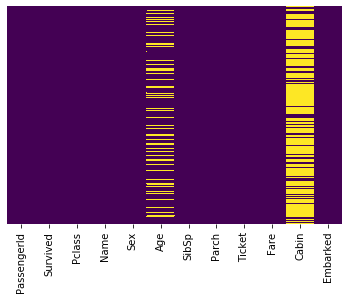

In [5]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

然後我們發現，大約有20％左右的Age資料是處於缺失的情況，這個比例足夠的小，也許我們可以嘗試用其他的方式將缺失的資料補齊，而Cabin欄位缺失情況則相當嚴重，我們可能會考慮直接放棄使用這個欄位．

我們可以繼續的透過對資料視覺化，來查看各種資料的可能，尋找資料之間的關聯性

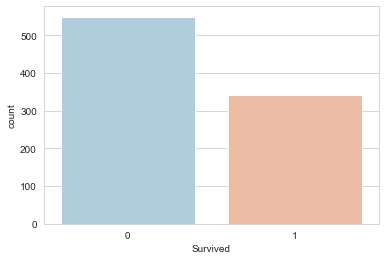

In [6]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=train,palette='RdBu_r')

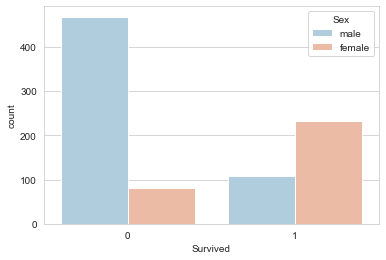

In [7]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train,palette='RdBu_r')

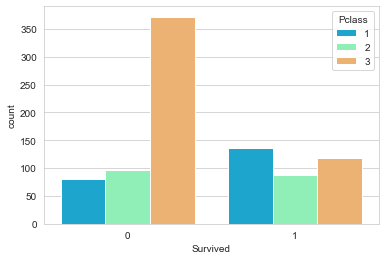

In [8]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=train,palette='rainbow')

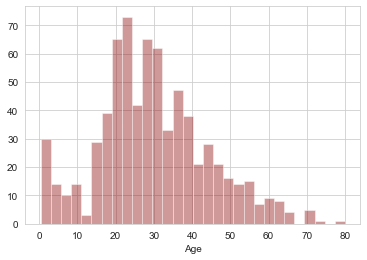

In [9]:
sns.distplot(train['Age'].dropna(),kde=False,color='darkred',bins=30)

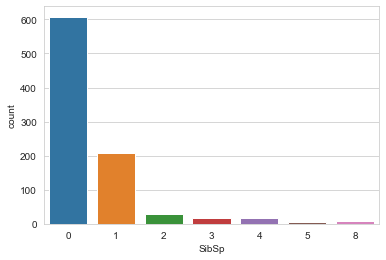

In [10]:
sns.countplot(x='SibSp',data=train)

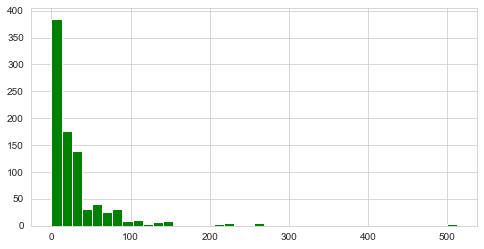

In [11]:
train['Fare'].hist(color='green',bins=40,figsize=(8,4))

___
## Data Cleaning

我們希望能將缺少的Age欄位填補上數據，而不是僅僅將缺少的部分刪除，一種方法是補上所有乘客的平均年齡（估算），但是這顯然不夠謹慎，我們或許可以嘗試依據各艙等乘客的年齡平均來做補值。

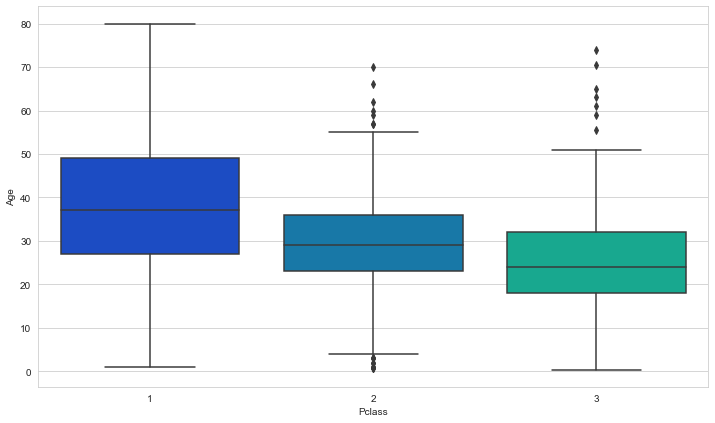

In [12]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

我們可以看到較高艙等中的乘客往往年齡較大，這似乎很符合我們一般的印象（年紀愈大，累積的資產越多），所以我們將根據各艙等平均年齡來對缺失的Age值做缺補值的處理

In [13]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

現在我們將這個function套用到Age欄位中

In [14]:
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)

讓我們再用heatmap圖做一次確認，檢查補值的結果

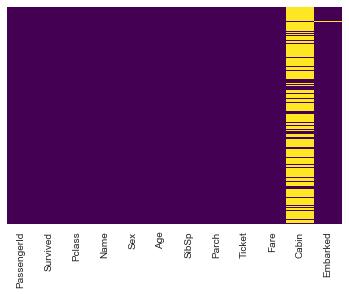

In [15]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

看起來結果相當好，Age欄位的缺失值已經被我們補上了各艙等年齡的平均數，現在讓我們接著處理Cabin欄位缺失的部分，這次我們將直接捨棄掉這個欄位，並且將資料集中剩餘有欄位缺失的資料捨棄掉

In [16]:
train.drop('Cabin',axis=1,inplace=True)

In [17]:
train.dropna(inplace=True)

## Converting Categorical Features 

機器學習演算法將無法直接使用分類特徵（例如：性別），所以我們需要使用pandas將分類特徵轉換為虛擬變量！

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Name           889 non-null object
Sex            889 non-null object
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Ticket         889 non-null object
Fare           889 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


In [19]:
sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)

In [20]:
train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [21]:
train = pd.concat([train,sex,embark],axis=1)

In [22]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


很好，現在我們已經完成資料的整理！

# Building a Logistic Regression model

讓我們首先將我們的數據拆分為訓練集和測試集

## Train Test Split

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived',axis=1), 
                                                    train['Survived'], test_size=0.30, 
                                                    random_state=101)

## Training and Predicting

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

/Users/sujuan/anaconda3/envs/AVM_instruction/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [27]:
predictions = logmodel.predict(X_test)

現在預測已經完成，讓我們看看我們的模型預測表現如何吧！

## Evaluation

我們可以使用分類報告檢查精確度，recall，f1-score，支持樣本數

In [28]:
from sklearn.metrics import classification_report

In [29]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.81      0.93      0.86       163
           1       0.85      0.65      0.74       104

   micro avg       0.82      0.82      0.82       267
   macro avg       0.83      0.79      0.80       267
weighted avg       0.82      0.82      0.81       267



看起來我們的模型預測率還不錯！